In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import scale, robust_scale
import scipy.stats
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
from sklearn.linear_model import ElasticNet
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from statsmodels.api import Logit
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.decomposition import PCA
import statsmodels.api as sm
from scipy.stats import shapiro
import warnings
warnings.filterwarnings('ignore')

In [4]:
df_raw = pd.read_csv('C:\Users\minid\Desktop/AIR_POLLUTION.csv')
df_raw

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-4-a913de399114>, line 1)

In [ ]:
df_raw.info()

## 1. 데이터 정제

In [3]:
# 날짜 데이터 처리
# 월과 요일이 영향을 끼칠 것이라고 가정하고 해당 데이터 추가
df_raw['MeasDate'] = pd.to_datetime(df_raw['MeasDate'])
df_raw['Month'] = df_raw['MeasDate'].dt.month #월
df_raw['Dayofweek'] = df_raw['MeasDate'].dt.dayofweek #요일

In [4]:
# 바람 데이터 변경
# 너무 세분화된 각도 대신 방향성 정도만 고려
df_raw['WIND_DIR2']= df_raw['WIND_DIR']//45

In [5]:
# 결측치 확인 및 처리
df_raw.isnull().sum()

MeasDate      0
PM10          1
O3            1
NO2           1
CO           55
SO2           1
TEMP          0
RAIN          0
WIND          0
WIND_DIR      0
HUMIDITY      0
ATM_PRESS     0
SNOW          0
CLOUD         0
Month         0
Dayofweek     0
WIND_DIR2     0
dtype: int64

In [6]:
# 결측치는 모두 기체 농도 데이터에 존재. 기체 농도는 주변 일자의 기체 농도와 비슷할 것으로 추측. 따라서 바로 앞 데이터 값으로 대체하고자 함.
df_raw.fillna(method='ffill', inplace=True)
# 결측치 채운 후 재확인
df_raw.isnull().sum()

MeasDate     0
PM10         0
O3           0
NO2          0
CO           0
SO2          0
TEMP         0
RAIN         0
WIND         0
WIND_DIR     0
HUMIDITY     0
ATM_PRESS    0
SNOW         0
CLOUD        0
Month        0
Dayofweek    0
WIND_DIR2    0
dtype: int64

<AxesSubplot:>

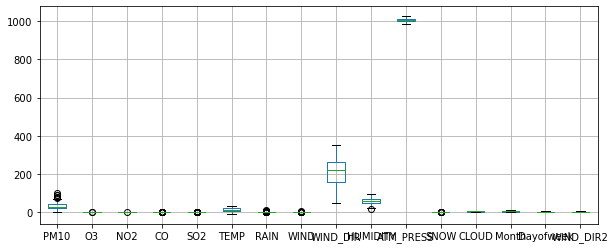

In [7]:
# 이상치 확인 및 처리
df_raw.boxplot(figsize=(10,4))

<AxesSubplot:>

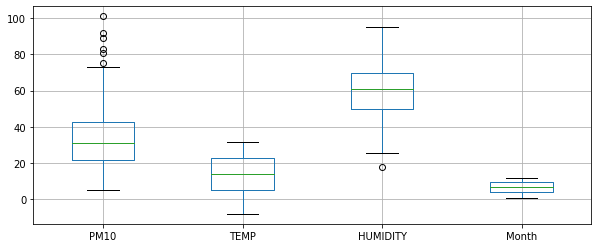

In [8]:
# 위의 그래프가 잘 보이지 않아 수치가 비슷한 열끼리 확인
df_temp1 = df_raw[['PM10','TEMP','HUMIDITY','Month']]
df_temp1.boxplot(figsize=(10,4))

In [9]:
# -> 미세먼지 75 이상이 이상치로 확인되었다.
# -> 습도 20% 이하가 이상치로 나왔으나, 실제로 가능한 경우이기 때문에 이상치로 판단하지 않는다.

<AxesSubplot:>

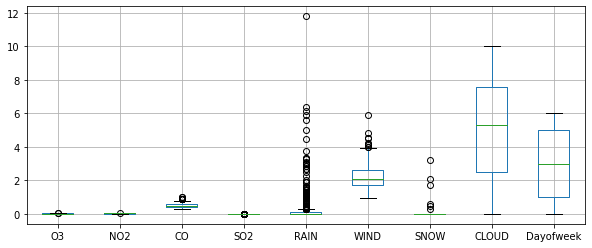

In [10]:
df_temp2 = df_raw[['O3','NO2','CO','SO2','RAIN','WIND','SNOW','CLOUD','Dayofweek']]
df_temp2.boxplot(figsize=(10,4))

In [11]:
# RAIN 변수에 이상치가 굉장히 많이 나왔는데 비가 오지 않은 날이 차지하는 비중이 커서 이상치가 많이 나온 것으로 예상된다.
# SNOW 변수도 마찬가지로 눈이 오지 않은 날이 차지하는 비중이 커서 눈이 온 날들이 이상치로 분류된 것으로 판단된다.

In [12]:
# -> 이상치를 적당한 기준으로 제거한다.
df = df_raw[(df_raw['PM10']<75) & (df_raw['RAIN']<4) & (df_raw['WIND']<5) & (df_raw['SNOW']<2)]
df

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD,Month,Dayofweek,WIND_DIR2
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.00,2.30,249,63.2,995.1,0.0,5.70,7,0,5
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.00,2.26,265,63.2,998.6,0.0,3.83,7,1,5
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.00,1.79,280,65.3,998.3,0.0,6.29,7,2,6
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.00,2.04,263,58.6,996.6,0.0,2.54,7,3,5
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.00,1.45,175,45.5,993.5,0.0,3.92,7,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2020-06-25,13.0,0.023,0.019,0.5,0.003,21.54,0.76,2.21,163,91.2,991.7,0.0,10.00,6,3,3
361,2020-06-26,19.0,0.039,0.016,0.4,0.003,21.66,0.41,3.12,228,84.0,996.0,0.0,8.73,6,4,5
362,2020-06-27,22.0,0.044,0.017,0.4,0.004,23.94,0.00,1.93,217,69.8,995.8,0.0,6.21,6,5,4
363,2020-06-28,27.0,0.044,0.009,0.4,0.003,25.03,0.00,2.35,283,71.3,994.7,0.0,2.63,6,6,6


In [13]:
df2 = df.drop(columns=['MeasDate','WIND_DIR'])
df2

,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,HUMIDITY,ATM_PRESS,SNOW,CLOUD,Month,Dayofweek,WIND_DIR2
0,29.0,0.054,0.021,0.5,0.003,24.03,0.00,2.30,63.2,995.1,0.0,5.70,7,0,5
1,26.0,0.053,0.020,0.5,0.003,24.29,0.00,2.26,63.2,998.6,0.0,3.83,7,1,5
2,30.0,0.042,0.023,0.4,0.003,24.18,0.00,1.79,65.3,998.3,0.0,6.29,7,2,6
3,28.0,0.034,0.026,0.4,0.003,25.35,0.00,2.04,58.6,996.6,0.0,2.54,7,3,5
4,29.0,0.045,0.035,0.5,0.003,27.30,0.00,1.45,45.5,993.5,0.0,3.92,7,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,13.0,0.023,0.019,0.5,0.003,21.54,0.76,2.21,91.2,991.7,0.0,10.00,6,3,3
361,19.0,0.039,0.016,0.4,0.003,21.66,0.41,3.12,84.0,996.0,0.0,8.73,6,4,5
362,22.0,0.044,0.017,0.4,0.004,23.94,0.00,1.93,69.8,995.8,0.0,6.21,6,5,4
363,27.0,0.044,0.009,0.4,0.003,25.03,0.00,2.35,71.3,994.7,0.0,2.63,6,6,6


## 2. 탐색적 분석

#### 목표변수 및 설명변수의 분포 확인

<AxesSubplot:>

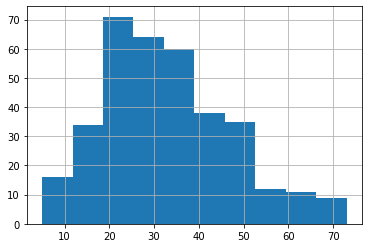

In [14]:
# 목표변수(PM10)의 분포
df2['PM10'].hist()

In [15]:
# 월별 미세먼지량 확인
group_month = df2.groupby(df2['Month'])
monthmean = group_month['PM10'].mean()

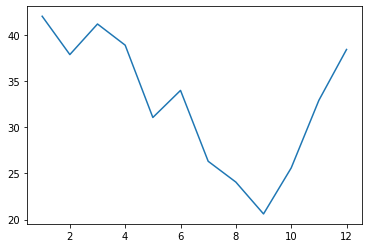

In [16]:
x = np.arange(1,13)
y = monthmean.values
plt.plot(x,y)
plt.show()

In [17]:
# -> 겨울과 봄에 미세먼지량의 평균이 높고, 여름과 겨울에 미세먼지 발생량의 평균이 낮은 경향을 보인다.

In [18]:
# 월별 미세먼지 발생량의 평균에 실제로 차이가 있는것인지 검정
f_result = stats.f_oneway(df2[(df2['Month']==1)]['PM10'], df2[(df2['Month']==2)]['PM10'], df2[(df2['Month']==3)]['PM10'], df2[(df2['Month']==4)]['PM10'], df2[(df2['Month']==5)]['PM10'], df2[(df2['Month']==6)]['PM10'], df2[(df2['Month']==7)]['PM10'], df2[(df2['Month']==8)]['PM10'], df2[(df2['Month']==9)]['PM10'], df2[(df2['Month']==10)]['PM10'], df2[(df2['Month']==11)]['PM10'], df2[(df2['Month']==12)]['PM10'])
f, p = f_result.statistic.round(3), f_result.pvalue.round(3)
print("F 통계량: {}".format(f))
print("p-value: {}".format(p))

F 통계량: 9.431
p-value: 0.0


In [19]:
# -> 검정 결과 그룹 간 평균 차이가 있다고 할 수 있다. 따라서 향후 분석에 활용한다.

In [20]:
# 요일별 미세먼지량 확인
group_dow = df2.groupby(df2['Dayofweek'])
dowmean = group_dow['PM10'].mean()

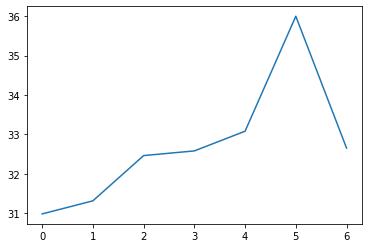

In [21]:
x = np.arange(0,7)
y = dowmean.values
plt.plot(x,y)
plt.show()

In [22]:
# -> 토요일의 미세먼지 발생량의 평균이 높은 경향을 보인다.

In [23]:
# 요일별 미세먼지 발생량의 평균에 실제로 차이가 있는것인지 검정
f_result = stats.f_oneway(df2[(df2['Dayofweek']==0)]['PM10'], df2[(df2['Dayofweek']==1)]['PM10'], df2[(df2['Dayofweek']==2)]['PM10'], df2[(df2['Dayofweek']==3)]['PM10'], df2[(df2['Dayofweek']==4)]['PM10'], df2[(df2['Dayofweek']==5)]['PM10'], df2[(df2['Dayofweek']==6)]['PM10'])
f, p = f_result.statistic.round(3), f_result.pvalue.round(3)
print("F 통계량: {}".format(f))
print("p-value: {}".format(p))

F 통계량: 0.646
p-value: 0.694


In [24]:
# -> 검정 결과 그룹 간 평균 차이가 있다고 할 수 없다. 따라서 향후 분석에 활용하지 않는다.
df2.drop(columns=['Dayofweek'], inplace=True)

In [25]:
# 중요도는 회귀계수의 절대값 크기
# CLOUD, WIND, TEMP, SO2, CO, NO2, O3의 값이 커질수록 PM10 값이 커진다. 265쪽 표와 비교
# 12월~4월은 PM10이 커지는 방향으로 영향을 미치고, 5월~11월은 PM10이 작아지는 방향으로 영향을 미친다.
# SO2, CO, Month의 영향력이 크다.# 풍향별 미세먼지량 확인
group_wdir = df2.groupby(df2['WIND_DIR2'])
wdirmean = group_wdir['PM10'].mean()
wdirmean

WIND_DIR2
1    30.740741
2    28.600000
3    34.754717
4    35.042857
5    34.315217
6    31.457143
7    14.625000
Name: PM10, dtype: float64

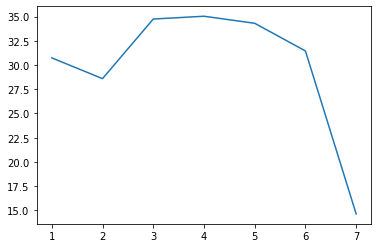

In [26]:
x = np.arange(1,8)
y = wdirmean.values
plt.plot(x,y)
plt.show()

In [27]:
# 남서쪽에서 바람이 불 때 미세먼지 발생량이 높은 경향을 보인다.

In [28]:
# 풍향별 미세먼지 발생량의 평균에 실제로 차이가 있는것인지 검정
f_result = stats.f_oneway(df2[(df2['WIND_DIR2']==1)]['PM10'], df2[(df2['WIND_DIR2']==2)]['PM10'], df2[(df2['WIND_DIR2']==3)]['PM10'], df2[(df2['WIND_DIR2']==4)]['PM10'], df2[(df2['WIND_DIR2']==5)]['PM10'], df2[(df2['WIND_DIR2']==6)]['PM10'], df2[(df2['WIND_DIR2']==5)]['PM10'], df2[(df2['WIND_DIR2']==7)]['PM10'])
f, p = f_result.statistic.round(3), f_result.pvalue.round(3)
print("F 통계량: {}".format(f))
print("p-value: {}".format(p))

F 통계량: 3.161
p-value: 0.003


In [29]:
# -> 검정 결과 그룹 간 평균 차이가 있다고 할 수 있다. 따라서 향후 분석에 활용한다.

In [85]:
# Scale 변환 (각 변수들이 서로 다른 수치와 단위를 갖고 있으므로 scale 변환을 해준다. 이상치 영향을 덜 받는 로버스트 변환 활용)
df2_scaled = robust_scale(df2)
df2_scaled = pd.DataFrame(df2_scaled, columns=df2.columns)
df2_scaled.tail(70)

,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,HUMIDITY,ATM_PRESS,SNOW,CLOUD,Month,WIND_DIR2
280,-0.95,0.411765,-0.642857,-0.5,-0.001,-0.220922,0.296296,1.461988,0.756688,-0.494024,0.0,0.589899,-0.5,0.0
281,-0.15,0.411765,-0.928571,-1.0,-0.001,-0.368575,0.000000,2.900585,-0.491720,-0.231076,0.0,-0.133333,-0.5,1.0
282,1.85,0.176471,-1.142857,-1.0,-0.001,-0.454938,0.000000,2.397661,-0.756688,-0.055777,0.0,-0.218182,-0.5,1.0
283,0.30,0.235294,-0.928571,-1.0,-0.001,-0.362446,0.000000,1.777778,-0.634395,-0.071713,0.0,-0.747475,-0.5,1.0
284,0.15,0.411765,-0.357143,-0.5,0.000,-0.258810,0.000000,2.140351,-0.262420,-0.247012,0.0,-0.789899,-0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,-0.90,0.000000,-0.428571,0.0,0.000,0.408692,11.259259,0.152047,1.566879,-1.179283,0.0,0.993939,-0.1,-0.5
346,-0.60,0.941176,-0.642857,-0.5,0.000,0.415378,6.074074,1.216374,1.200000,-0.836653,0.0,0.737374,-0.1,0.5
347,-0.45,1.235294,-0.571429,-0.5,0.001,0.542415,0.000000,-0.175439,0.476433,-0.852590,0.0,0.228283,-0.1,0.0
348,-0.20,1.235294,-1.142857,-0.5,0.000,0.603148,0.000000,0.315789,0.552866,-0.940239,0.0,-0.494949,-0.1,1.0


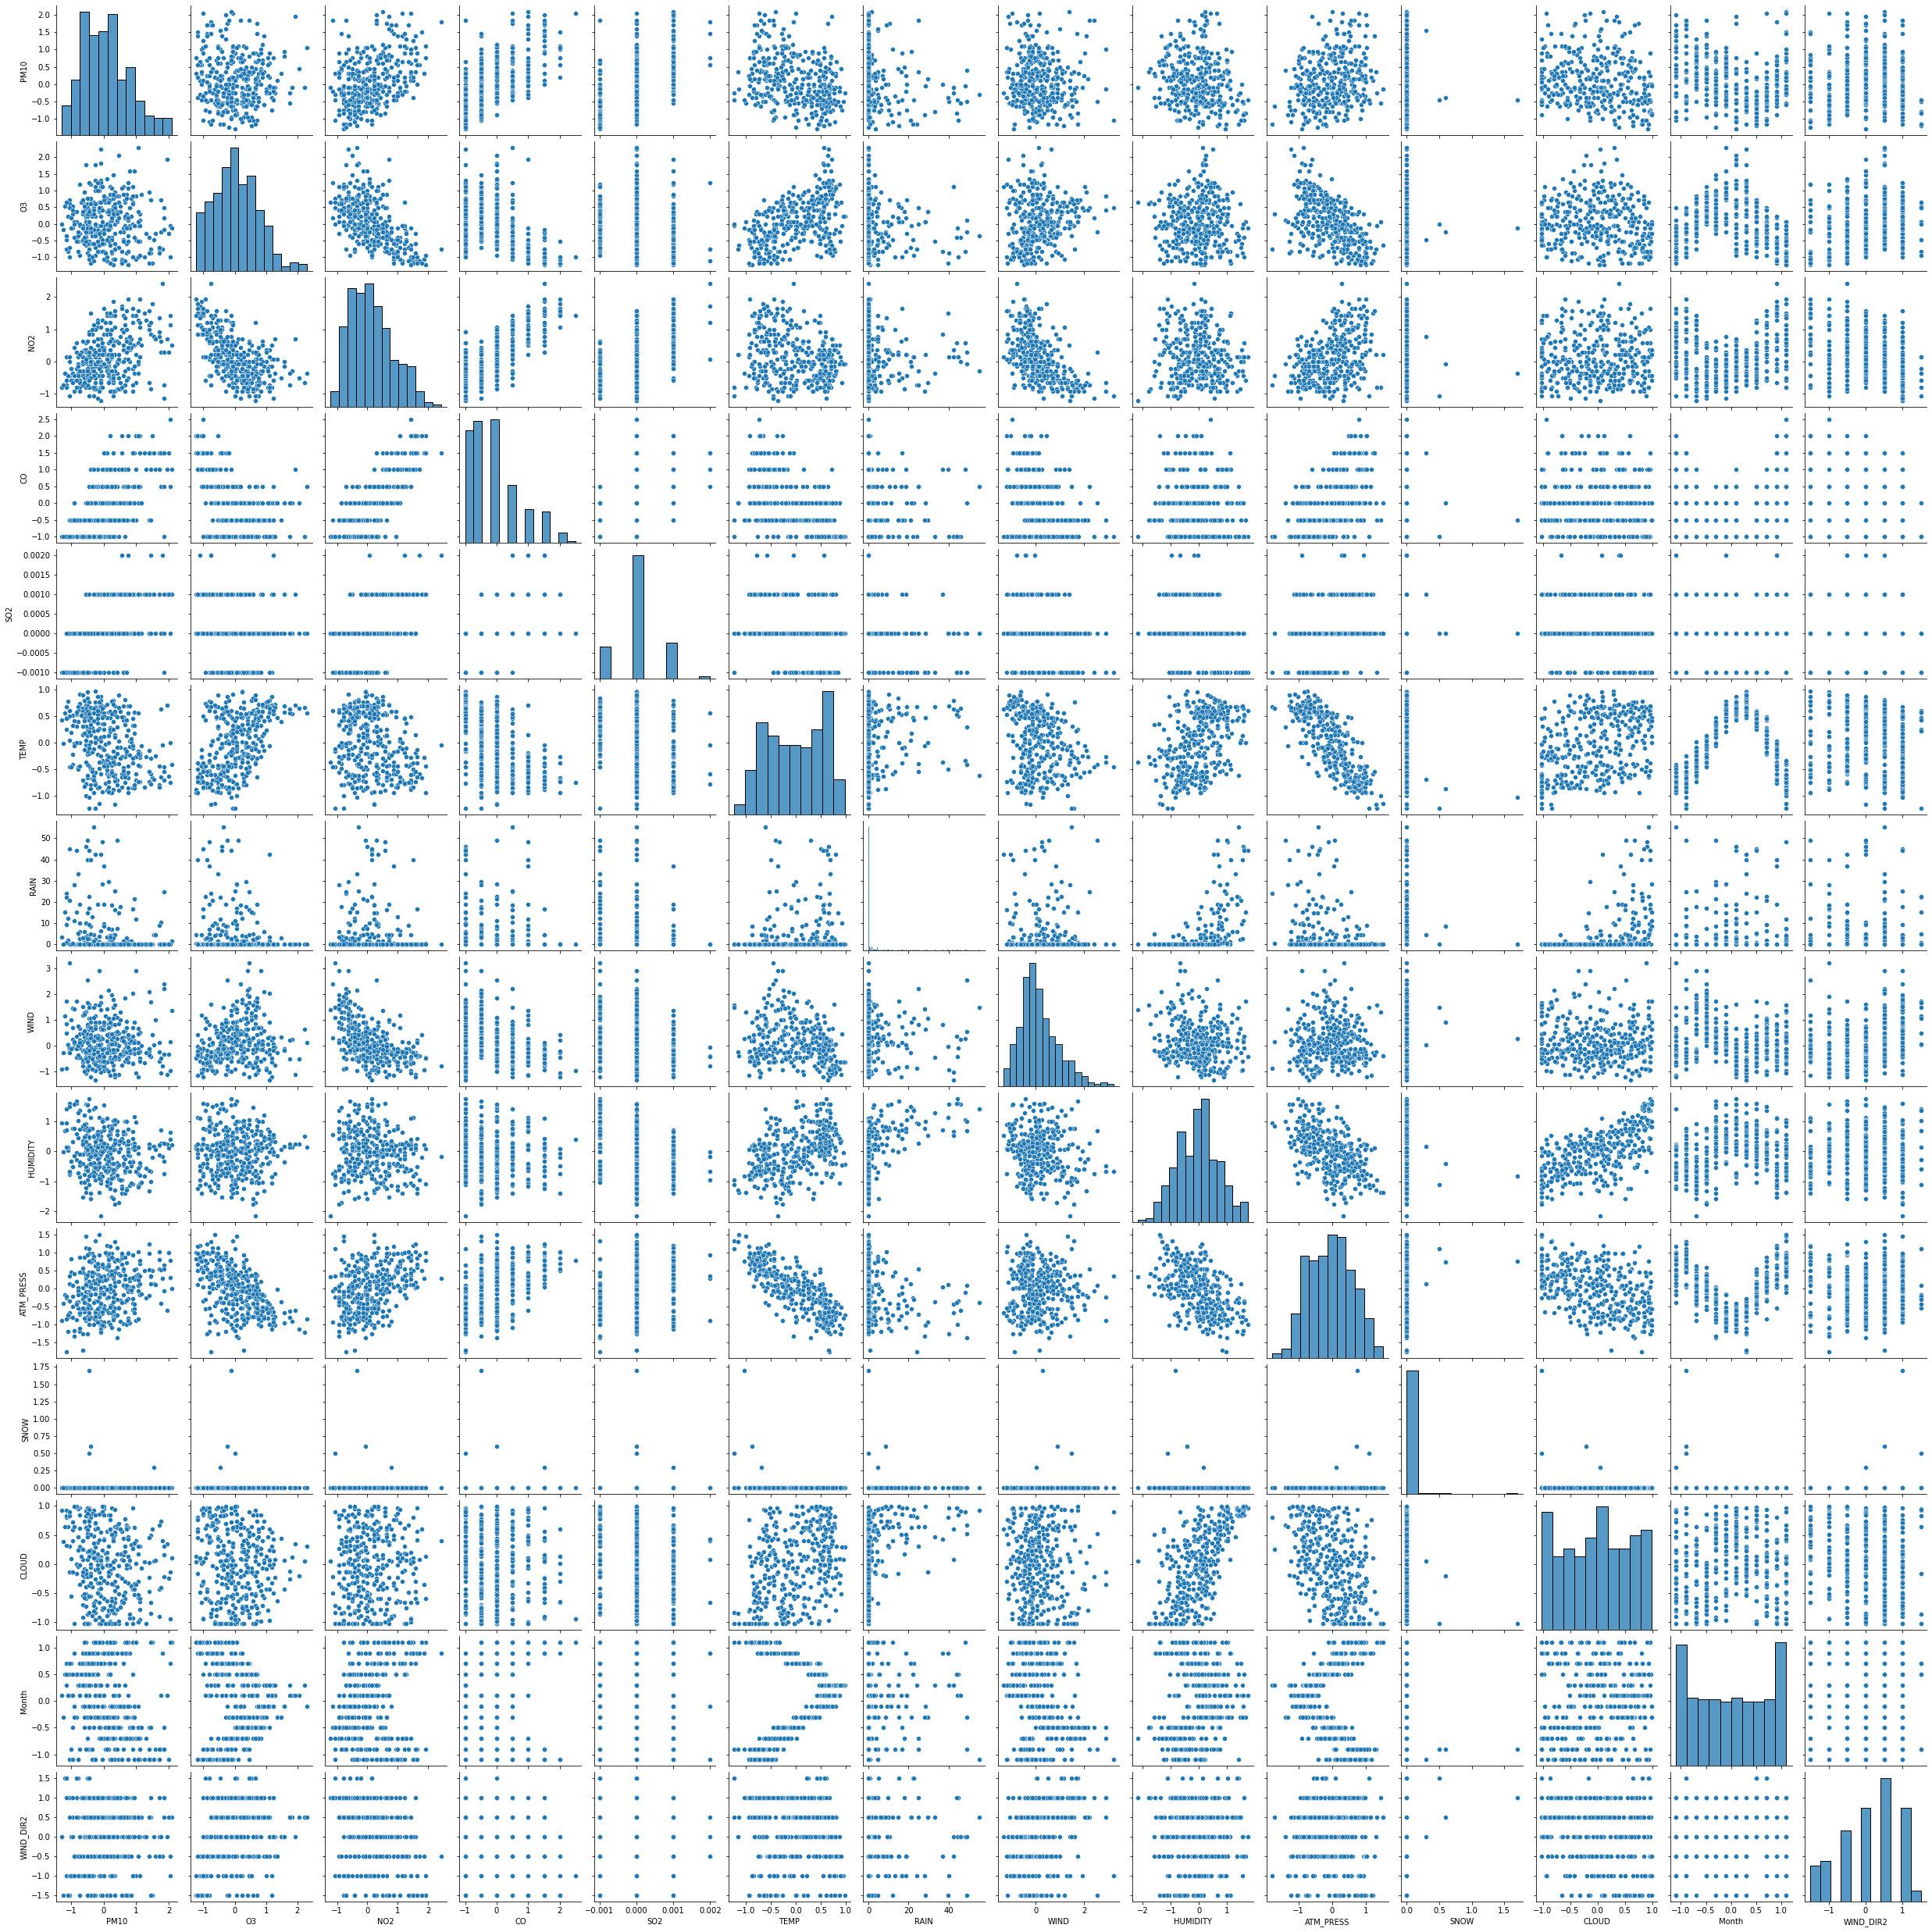

In [31]:
# 변수 간의 경향성 파악
sns.pairplot(df2_scaled)

In [32]:
# -> 목표 변수와 상관관계가 있어 보이는 잠재 인자: NO2
# 서로 상관관계가 보이는 설명변수: O3와 NO2, O3와 ATM_PRESS, TEMP와 ATM_PRESS, HUMIDITY와 CLOUD

## 3. 예측

### 3.1 다중선형회귀

In [33]:
# 회귀 모델 생성: 설명 변수 전체
# 선형 회귀 분석
reg_model = smf.ols(formula = 'PM10 ~ O3+NO2+CO+SO2+TEMP+RAIN+WIND+HUMIDITY+ATM_PRESS+SNOW+CLOUD+C(Month)+C(WIND_DIR2)', data=df2_scaled)
# 적합
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     23.88
Date:                Sun, 23 May 2021   Prob (F-statistic):           2.80e-62
Time:                        21:15:30   Log-Likelihood:                -183.71
No. Observations:                 350   AIC:                             425.4
Df Residuals:                     321   BIC:                             537.3
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0909 

In [34]:
# -> 분산분석 결과 p값이 유의수준 0.05보다 작으므로 회귀모델로서 유의
# -> 설명력: 0.647
# -> 회귀계수 검정: WIND_DIR2 일부, Month 일부, O3, NO2, CO, TEMP, RAIN, WIND 의 p값이 유의수준 0.05보다 작으므로 유의

In [35]:
# 회귀 모델 생성: SO2 제거
# 선형 회귀 분석
reg_model2 = smf.ols(formula = 'PM10 ~ O3+NO2+CO+TEMP+RAIN+WIND+C(WIND_DIR2)+HUMIDITY+ATM_PRESS+SNOW+CLOUD+C(Month)', data=df2_scaled)
# 적합
reg_result2 = reg_model2.fit()
print(reg_result2.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     24.49
Date:                Sun, 23 May 2021   Prob (F-statistic):           2.43e-62
Time:                        21:17:16   Log-Likelihood:                -185.37
No. Observations:                 350   AIC:                             426.7
Df Residuals:                     322   BIC:                             534.8
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0738 

In [36]:
# -> 분산분석 결과 p값이 유의수준 0.05보다 작으므로 회귀모델로서 유의
# -> 설명력: 0.645
# -> 회귀계수 검정: WIND_DIR2 일부, Month 일부, O3, NO2, CO, TEMP, RAIN, WIND 의 p값이 유의수준 0.05보다 작으므로 유의

In [42]:
# 회귀모델 생성: 설명변수 간의 다중공선성 확인
df_x = df2_scaled.drop(['PM10','SO2'], axis=1)
df_x_const = add_constant(df_x)
df_vif = pd.DataFrame()
df_vif['variable'] = df_x_const.columns
df_vif['VIF'] = [variance_inflation_factor(df_x_const.values, i) for i in range(df_x_const.shape[1])]
df_vif.sort_values('VIF', inplace=True)
df_vif.round(3)

,variable,VIF
9,SNOW,1.060
11,Month,1.339
12,WIND_DIR2,1.403
5,RAIN,1.563
0,const,1.738
6,WIND,1.953
10,CLOUD,2.082
7,HUMIDITY,2.705
1,O3,3.073
3,CO,4.379


In [38]:
# -> TEMP의 다중공선성이 가장 높게 나왔으나 위의 회귀계수 검정에서 유의미한 변수로 판단되었으므로 삭제하지 않는다.
# 대신, TEMP와 연관성이 높은데 유의미하지 않고 다중공선성이 높은 편인 ATM_PRESS를 삭제해본다.# 중요도는 회귀계수의 절대값 크기
# CLOUD, WIND, TEMP, SO2, CO, NO2, O3의 값이 커질수록 PM10 값이 커진다. 265쪽 표와 비교
# 12월~4월은 PM10이 커지는 방향으로 영향을 미치고, 5월~11월은 PM10이 작아지는 방향으로 영향을 미친다.
# SO2, CO, Month의 영향력이 크다.

In [43]:
# 회귀모델 생성: ATM_PRESS 제거 후 설명변수 다중공선성 재확인
df_x2 = df2_scaled.drop(['PM10','SO2','ATM_PRESS'], axis=1)
df_x2_const = add_constant(df_x2)
df_vif2 = pd.DataFrame()
df_vif2['variable'] = df_x2_const.columns
df_vif2['VIF'] = [variance_inflation_factor(df_x2_const.values, i) for i in range(df_x2_const.shape[1])]
df_vif2.sort_values('VIF', inplace=True)
df_vif2.round(3)

,variable,VIF
8,SNOW,1.060
10,Month,1.269
11,WIND_DIR2,1.365
5,RAIN,1.543
0,const,1.690
6,WIND,1.934
9,CLOUD,2.071
7,HUMIDITY,2.562
1,O3,3.007
3,CO,4.336


In [44]:
# 회귀모델 생성: 설명변수 다중공선성 처리 (ATM_PRESS 제외)
# 선형 회귀 분석
reg_model3 = smf.ols(formula = 'PM10 ~ O3+NO2+CO+TEMP+RAIN+WIND+C(WIND_DIR2)+HUMIDITY+SNOW+CLOUD+C(Month)', data=df2_scaled)
# 적합
reg_result3 = reg_model3.fit()
print(reg_result2.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     24.49
Date:                Sun, 23 May 2021   Prob (F-statistic):           2.43e-62
Time:                        21:22:16   Log-Likelihood:                -185.37
No. Observations:                 350   AIC:                             426.7
Df Residuals:                     322   BIC:                             534.8
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0738 

In [41]:
# -> 분산분석 결과 p값이 유의수준 0.05보다 작으므로 회귀모델로서 유의
# -> 설명력: 0.645
# -> 회귀계수 검정: WIND_DIR2 일부, Month 일부, O3, NO2, CO, TEMP, RAIN, WIND 의 p값이 유의수준 0.05보다 작으므로 유의

In [45]:
# 상관관계가 높은 것으로 보이는 CLOUD와 HUMIDITY 중에 HUMIDITY를 삭제해본다.
# 회귀모델 생성: 설명변수 다중공선성 재확인 (HUMIDITY 삭제)
df_x3 = df2_scaled.drop(['PM10','SO2','ATM_PRESS','HUMIDITY'], axis=1)
df_x3_const = add_constant(df_x3)
df_vif3 = pd.DataFrame()
df_vif3['variable'] = df_x3_const.columns
df_vif3['VIF'] = [variance_inflation_factor(df_x3_const.values, i) for i in range(df_x3_const.shape[1])]
df_vif3.sort_values('VIF', inplace=True)
df_vif3.round(3)

,variable,VIF
7,SNOW,1.059
9,Month,1.252
5,RAIN,1.288
10,WIND_DIR2,1.323
0,const,1.690
8,CLOUD,1.747
6,WIND,1.851
1,O3,2.850
3,CO,3.831
4,TEMP,3.859


In [46]:
# 회귀모델 생성: 설명변수 다중공선성 처리 (HUMIDITY 제외)
# 선형 회귀 분석
reg_model4 = smf.ols(formula = 'PM10 ~ O3+NO2+CO+TEMP+RAIN+WIND+C(WIND_DIR2)+SNOW+CLOUD+C(Month)', data=df2_scaled)
# 적합
reg_result4 = reg_model4.fit()
print(reg_result3.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     25.49
Date:                Sun, 23 May 2021   Prob (F-statistic):           5.17e-63
Time:                        21:23:47   Log-Likelihood:                -185.47
No. Observations:                 350   AIC:                             424.9
Df Residuals:                     323   BIC:                             529.1
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0785 

In [47]:
# -> 분산분석 결과 p값이 유의수준 0.05보다 작으므로 회귀모델로서 유의
# -> 설명력: 0.646
# -> 회귀계수 검정: WIND_DIR2 일부, Month 일부, O3, NO2, CO, TEMP, RAIN, WIND 의 p값이 유의수준 0.05보다 작으므로 유의

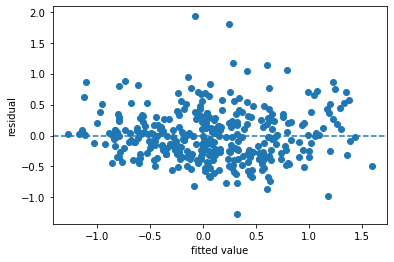

In [48]:
# 다중회귀 잔차 검증
# 잔차 산점도
plt.scatter(reg_result4.fittedvalues, reg_result4.resid)
plt.xlabel('fitted value')
plt.ylabel('residual')
plt.axhline(y=0, linestyle="--")

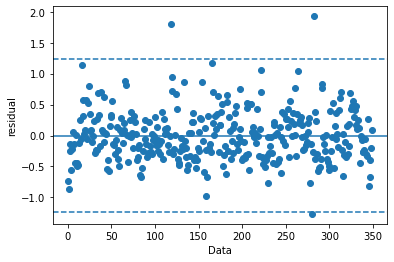

In [49]:
# 잔차의 독립성 확인
plt.scatter(df2_scaled.index, reg_result4.resid, marker='o')
plt.xlabel('Data')
plt.ylabel('residual')
plt.axhline(y=0, linestyle="-")
plt.axhline(y=3*np.std(reg_result4.resid), linestyle="--")
plt.axhline(y=-3*np.std(reg_result4.resid), linestyle="--")

NormaltestResult(statistic=45.813746041250766, pvalue=1.1263450362802085e-10)

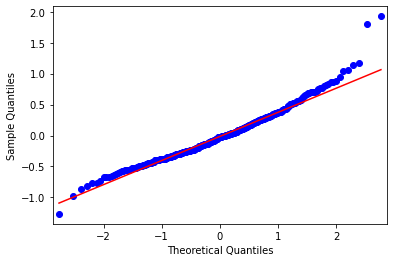

In [50]:
# 잔차 정규성 검정
qqplot(reg_result4.resid, line='q')
from statsmodels.stats.stattools import omni_normtest
omni_normtest(reg_result3.resid, axis=0)

<AxesSubplot:>

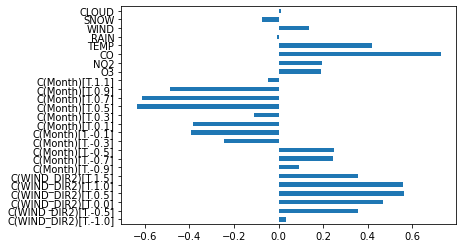

In [51]:
# 설명변수 중요도
df_coef = pd.DataFrame({'Coef': reg_result4.params.values[1:]},index =reg_result4.params.index[1:])
df_coef.plot.barh(y='Coef', legend=False)

In [52]:
# 중요도는 회귀계수의 절대값 크기
# CLOUD, WIND, TEMP, CO, NO2, O3의 값이 커질수록 PM10 값이 커진다.
# CO, Month의 영향력이 크다.

### 3.2 의사결정나무

In [53]:
df_y = df2['PM10']
df_x = df2.drop('PM10', axis=1, inplace=False)

In [54]:
# 전체 데이터 수가 적으므로 Train data의 충분한 학습을 위해 Test data의 크기를 너무 크지 않게 설정한다.
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size=0.25, random_state=1234)

print('train data X size: {}'.format(df_train_x.shape))
print('train data Y size: {}'.format(df_train_y.shape))
print('test data X size: {}'.format(df_test_x.shape))
print('test data Y size: {}'.format(df_test_y.shape))

train data X size: (262, 13)
train data Y size: (262,)
test data X size: (88, 13)
test data Y size: (88,)


In [55]:
# 모델 생성
# 기본 옵션으로 모델 생성
tree_uncustomized = DecisionTreeRegressor(random_state =1234)
tree_uncustomized.fit(df_train_x, df_train_y)

print('score on training set : ',tree_uncustomized.score(df_train_x, df_train_y))
print('score on test set : ',tree_uncustomized.score(df_test_x, df_test_y))

score on training set :  1.0
score on test set :  0.010022744493583535


In [56]:
# GridSearchCV를 이용한 최적의 parameter 찾기
estimator =DecisionTreeRegressor()
para_depth = [n for n in range(1,11)]
para_split = [n*2 for n in range(2,20)]
para_leaf = [n*1 for n in range(1,20)]
param_grid = {'criterion': ['mse'], 'max_features':['auto','sqrt','log2']
             , 'max_depth':para_depth, 'min_samples_split': para_split
             , 'min_samples_leaf':para_leaf}
grid_df = GridSearchCV(estimator, param_grid, scoring='r2', n_jobs= -1)
grid_df.fit(df_train_x, df_train_y)

print("best estimator model : ", grid_df.best_estimator_)
print("best parameter: ", grid_df.best_params_)
print("best score: ", grid_df.best_score_.round(3))

best estimator model :  DecisionTreeRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=10,
                      min_samples_split=32)
best parameter:  {'criterion': 'mse', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 32}
best score:  0.436


In [57]:
tree_final = DecisionTreeRegressor(min_samples_leaf=10, min_samples_split=32, max_depth=10, random_state=1234,)
tree_final.fit(df_train_x, df_train_y)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=10, min_samples_split=32,
                      random_state=1234)

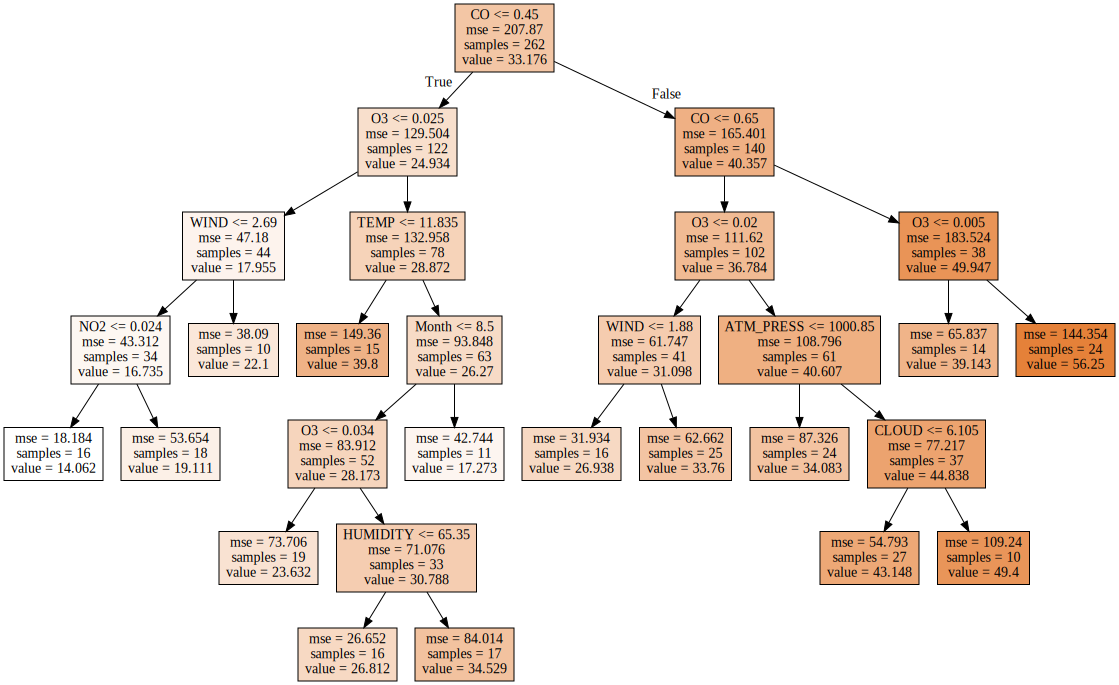

In [58]:
v_feature_name = df_train_x.columns

export_graphviz(tree_final, out_file='tree_final.dot', feature_names=v_feature_name, impurity=True, filled=True)

with open('tree_final.dot') as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

In [59]:
# 의사결정나무 모델의 성능은 best score:0.436 으로 좋지 않음
# 다만, 의사결정나무 그림을 통해 CO, O3가 중요변수라는 것을 볼 수 있다.

### 3.3 랜덤포레스트

In [60]:
# 모델 생성
# 기본 옵션으로 모델 생성
rf_uncustomized = RandomForestRegressor(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)

print("Score on training set:{:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))
print("Score on test set:{:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))

Score on training set:0.938
Score on test set:0.510


In [61]:
# GridSearchCV를 이용한 최적의 parameter 찾기
estimator = RandomForestRegressor(random_state=1234)
param_grid={"criterion":["mse"],"max_features":["auto", "sqrt","log2"], "max_depth": [depth for depth in range(1,10)] , 
            "min_samples_split":[split*2 for split in range(1,10)], "min_samples_leaf":[leaf for leaf in range(1,10)]}

grid_dt=GridSearchCV(estimator, param_grid, scoring="r2", n_jobs=-1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model:\n{}".format(grid_dt.best_estimator_))
print("\nbest parameter:\n{}".format(grid_dt.best_params_))
print("\nbest score:\n{}".format(grid_dt.best_score_.round(3)))

best estimator model:
RandomForestRegressor(max_depth=8, min_samples_leaf=4, random_state=1234)

best parameter:
{'criterion': 'mse', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2}

best score:
0.521


In [62]:
# 최종 모델 선정
rf_final = RandomForestRegressor(min_samples_leaf=4, min_samples_split=2, max_depth=8, random_state=1234,)
rf_final.fit(df_train_x, df_train_y)

RandomForestRegressor(max_depth=8, min_samples_leaf=4, random_state=1234)

In [63]:
# 랜덤포레스트의 best score: 0.521

Text(0, 0.5, '변수')

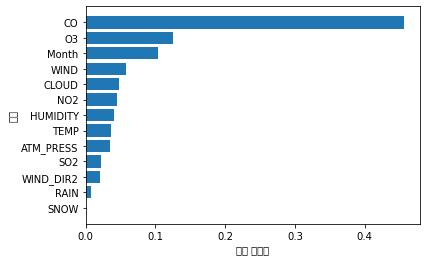

In [64]:
# 설명변수의 중요도
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rf_final.feature_importances_

df_importance.sort_values('Importance', ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

In [65]:
# 중요 설명변수: CO, O3, Month 순
# 단, 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 데이터에 따라 중요도가 변경될 수 있음

### 3.4 그래디언트 부스팅

In [66]:
# 모델 생성
# 기본 옵션으로 모델 생성
gb_uncustomized = GradientBoostingRegressor(random_state=1234)
gb_uncustomized.fit(df_train_x, df_train_y)

print("Score on training set: {:.3f}".format(gb_uncustomized.score(df_train_x, df_train_y)))
print("Score on test set: {:.3f}".format(gb_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 0.929
Score on test set: 0.434


In [67]:
# GridSearchCV를 이용한 최적의 parameter 찾기
estimator = GradientBoostingRegressor(random_state=1234)
param_grid={"criterion":["mse"],"max_features":["auto", "sqrt","log2"], "max_depth": [depth for depth in range(1,10)] , 
            "min_samples_split":[split*2 for split in range(1,10)], "min_samples_leaf":[leaf for leaf in range(1,10)], "learning_rate":[lr*0.1 for lr in range(1,10)]}

grid_gb=GridSearchCV(estimator, param_grid, scoring="r2", n_jobs=-1)
grid_gb.fit(df_train_x, df_train_y)

print("best estimator model:\n{}".format(grid_gb.best_estimator_))
print("\nbest parameter:\n{}".format(grid_gb.best_params_))
print("\nbest score:\n{}".format(grid_gb.best_score_.round(3)))

best estimator model:
GradientBoostingRegressor(criterion='mse', learning_rate=0.4, max_depth=1,
                          max_features='auto', min_samples_leaf=7,
                          random_state=1234)

best parameter:
{'criterion': 'mse', 'learning_rate': 0.4, 'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 7, 'min_samples_split': 2}

best score:
0.572


In [70]:
# 최종 모델 선정
gb_final = GradientBoostingRegressor(random_state=1234, min_samples_leaf=7, min_samples_split=2, max_depth=1, learning_rate=0.4)
gb_final.fit(df_train_x, df_train_y)

GradientBoostingRegressor(learning_rate=0.4, max_depth=1, min_samples_leaf=7,
                          random_state=1234)

Text(0, 0.5, '변수')

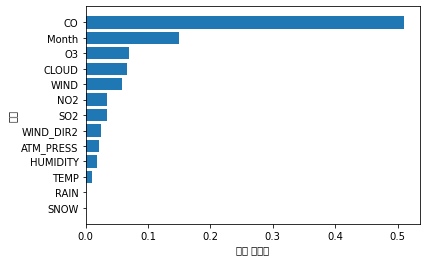

In [71]:
# 설명 변수의 중요도
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = gb_final.feature_importances_

df_importance.sort_values('Importance', ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

In [ ]:
# 중요 설명변수: CO, MONTH, O3 순
# 단, 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 데이터에 따라 중요도가 변경될 수 있음

## 4. 모델 평가 및 결론

다중선형회귀, 의사결정나무, 랜덤포레스트, 그래디언트 부스팅 모델 사용 결과 다중선형회귀의 성능이 가장 좋았다.
위의 모델을 종합해보았을 때, 중요한 변수는 TEMP, CO, NO2, O3, Month, WIND_DIR2, WIND 로 추릴 수 있다.

### 최종 모델

In [78]:
# 가장 성능이 좋고 해석이 쉬운 선형회귀모델로 선정 (위에서 정한 중요변수 활용)
# 선형 회귀 분석
reg_model_final = smf.ols(formula = 'PM10 ~ O3+CO+C(Month)+WIND+NO2+C(WIND_DIR2)+TEMP', data=df2_scaled)
# 적합
reg_result_final = reg_model_final.fit()
print(reg_result_final.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     29.68
Date:                Sun, 23 May 2021   Prob (F-statistic):           1.07e-64
Time:                        22:38:21   Log-Likelihood:                -188.64
No. Observations:                 350   AIC:                             423.3
Df Residuals:                     327   BIC:                             512.0
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0997 

In [87]:
# 최종회귀모델
# PM10 =  -0.0997 + 0.0620C(Month)[T.-0.9] + 0.2437C(Month)[T.-0.7] + 0.2544C(Month)[T.-0.5] - 0.2650C(Month)[T.-0.3] - 0.4124C(Month)[T.-0.1] - 0.4178C(Month)[T.0.1] - 0.1636C(Month)[T.0.3] - 0.6434C(Month)[T.0.5] - 0.6052C(Month)[T.0.7] - 0.4913C(Month)[T.0.9] - 0.0480C(Month)[T.1.1] + 0.0242C(WIND_DIR2)[T.-1.0] + 0.3479C(WIND_DIR2)[T.-0.5] + 0.4563C(WIND_DIR2)[T.0.0] + 0.5536C(WIND_DIR2)[T.0.5] + 0.5490C(WIND_DIR2)[T.1.0] + 0.3384C(WIND_DIR2)[T.1.5] + 0.2228O3 + 0.7231CO + 0.1109WIND + 0.1965NO2 + 0.3937TEMP
# 분산분석 결과 p값이 유의수준 0.05보다 작으므로 회귀모델로서 유의
# 설명력: 0.644
# 해석
# Month가 2월~4월이면 미세먼지 발생량과 양의 상관관계, 5월~11월이면 미세먼지 발생량과 음의 상관관계를 가짐
# WIND_DIR2, O3, CO, WIND, NO2, TEMP는 미세먼지 발생량과 양의 상관관계를 가짐